<a href="https://colab.research.google.com/github/alaeddinehamroun/Natural-Language-Processing/blob/main/Text_Classification_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install datasets transformers[torch]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from datasets import list_datasets

all_datasets = list_datasets()

print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 44516 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [9]:
from datasets import load_dataset

emotions = load_dataset("emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [11]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [12]:
len(train_ds)

16000

In [13]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [14]:
train_ds.column_names

['text', 'label']

In [15]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [16]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [17]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


In [18]:
# From Dataset to DataFrame

import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [19]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


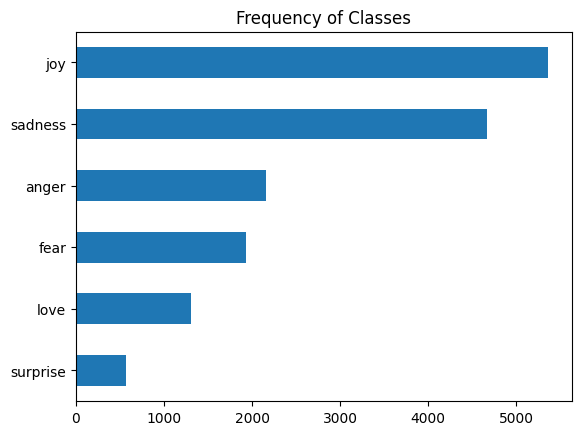

In [20]:
# Visaulizing the Class Distribution

import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

The dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and surprise are about 5-10 times rarers.
There are several ways to deal with imbalanced data, including:
* Randomly oversample the minority class
* Randomly undersample the majority class
* Gather more labeled data from the underrepresented classes



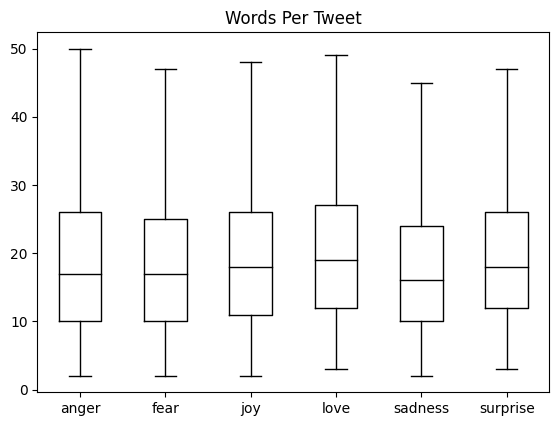

In [21]:
# Tweet lengths per emotion
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

From the plot we see that for each emotion, most tweets are around 15 words long
and the longest tweets are well below DistilBERT’s maximum context size. Texts that
are longer than a model’s context size need to be truncated, which can lead to a loss in
performance if the truncated text contains crucial information; in this case, it looks
like that won’t be an issue.

In [22]:
# Reset the output format of dataset
emotions.reset_format()

Transformer models like DistilBERT cannot receive raw strings as input; instead, they
assume the text has been tokenized and encoded as numerical vectors.

In [23]:
# Tokenization

# Technique 1: Character tokenization
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)
  # numericalization: This gives us a mapping from each character in our vocabulary to a unique integer
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)
# We can now use token2idx to transform the tokenized text to a list of integers:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)
# The last step is to convert input_ids to a 2D tensor of one-hot vectors. REASON: TO AVOID ORDERING
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']
{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}
[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]
Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [24]:
# Technique 2: Word Tokenization
tokenized_text = text.split()
print(tokenized_text)
# we can already see one potential problem with this
# tokenization scheme: punctuation is not accounted for, so NLP. is treated as a single
# token. Given that words can include declinations, conjugations, or misspellings, the
# size of the vocabulary can easily grow into the millions!

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


In [19]:
# Technique 3: subword tokenization


The basic idea behind subword tokenization is to combine the best aspects of charac‐
ter and word tokenization. On the one hand, we want to split rare words into smaller
units to allow the model to deal with complex words and misspellings. On the other
hand, we want to keep frequent words as unique entities so that we can keep the
length of our inputs to a manageable size. The main distinguishing feature of
subword tokenization (as well as word tokenization) is that it is learned from the pre‐
training corpus using a mix of statistical rules and algorithms.
There are several subword tokenization algorithms that are commonly used in NLP, but let’s start with WordPiece,5 which is used by the BERT and DistilBERT tokenizers.

In [25]:
# Loading the tokenizer for DistilBERT
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [26]:
encoded_text = tokenizer(text)
print(encoded_text)
# Convert back into tokens
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [22]:
# We can observe three things here. First, some special [CLS] and [SEP] tokens have
# been added to the start and end of the sequence. These tokens differ from model to
# model, but their main role is to indicate the start and end of a sequence. Second, the
# tokens have each been lowercased, which is a feature of this particular checkpoint.
# Finally, we can see that “tokenizing” and “NLP” have been split into two tokens,
# which makes sense since they are not common words. The ## prefix in ##izing and
# ##p means that the preceding string is not whitespace; any token with this prefix
# should be merged with the previous token when you convert the tokens back to a
# string.

In [27]:
# Converting tokens to string
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [28]:
# Other infos about the tokenizer
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


When using pretrained models, it is really important to make sure
that you use the same tokenizer that the model was trained with.
From the model’s perspective, switching the tokenizer is like shuf‐
fling the vocabulary. If everyone around you started swapping
random words like “house” for “cat,” you’d have a hard time under‐
standing what was going on too!

In [29]:
# Tokenizing thie whole dataset
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [30]:
# Passing a batch of two examples from the training set:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}





The attention mask allows
the model to ignore the padded parts of the input.

In [31]:
# Tokenizing the whole dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [32]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Training a Text Classifier

Two options:
* Feature extraction: We use the hidden states as features and just train a classifier on them, without modifying the pretrained model.
* Fine-tuning: We train the whole model end-to-end, which also updates the parameters of the pretrained model.

In [33]:
# Option one: using pretrained models
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
# Extracting the last hidden states
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [35]:
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad(): # to disable the automatic calculation of the gradient
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [36]:
outputs.last_hidden_state.size()
# returns [batch_size, n_tokens, hidden_dim]: 768-dimensional vector is
# returned for each of the 6 input tokens.

torch.Size([1, 6, 768])

In [37]:
# For classification tasks, it is common practice to just use the hidden state associated with the [CLS] token
# as the input feature
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [38]:
# Extracting the last hidden state for each string, in batches
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:, 0].cpu().numpy()}


In [39]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)
emotions_hidden["train"].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

Now that we have the hidden states associated with each tweet, the next step is to
train a classifier on them.

In [40]:
# Using the hidden states as input features and the labels as targets
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [41]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
# Visualizing the training set
# We'll use the UMAP algorithm to project the vectors down to 2D.
# Since UMAP works best when the features are scaled to lie in the [0,1] interval,
# we'll first apply a MinMaxScaler
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.579472,6.403979,0
1,-2.730236,5.972702,0
2,5.473777,2.760597,3
3,-2.366809,3.704432,2
4,-3.167409,4.033630,3


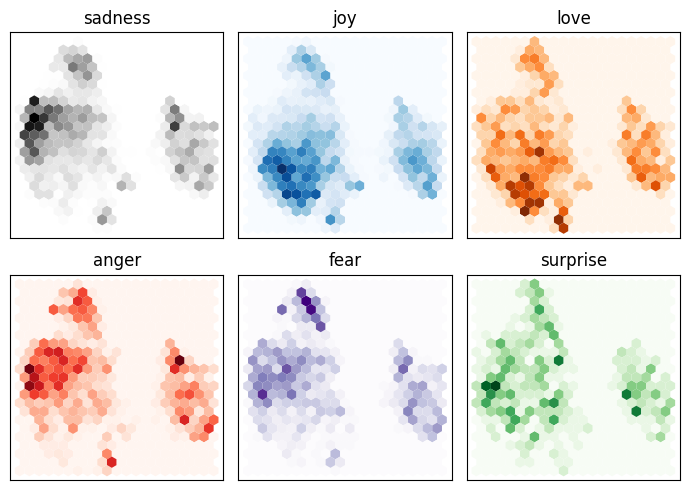

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

From this plot we can see some clear patterns: the negative feelings such as sadness,
anger, and fear all occupy similar regions with slightly varying distributions. On the
other hand, joy and love are well separated from the negative emotions and also
share a similar space. Finally, surprise is scattered all over the place. Although we
may have hoped for some separation, this is in no way guaranteed since the model
was not trained to know the difference between these emotions. It only learned them
implicitly by guessing the masked words in texts.

In [44]:
from sklearn.linear_model import LogisticRegression

# We increase 'max_iter' to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

Looking at the accuracy, it might appear that our model is just a bit better than ran‐
dom—but since we are dealing with an unbalanced multiclass dataset, it’s actually sig‐
nificantly better. We can examine whether our model is any good by comparing it
against a simple baseline. In Scikit-learn there is a DummyClassifier that can be used
to build a classifier with simple heuristics such as always choosing the majority class
or always drawing a random class. In this case the best-performing heuristic is to
always choose the most frequent class, which yields an accuracy of about 35%:

In [45]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

So, our simple classifier with DistilBERT embeddings is significantly better than our
baseline. We can further investigate the performance of the model by looking at the
confusion matrix of the classifier, which tells us the relationship between the true and
predicted labels:

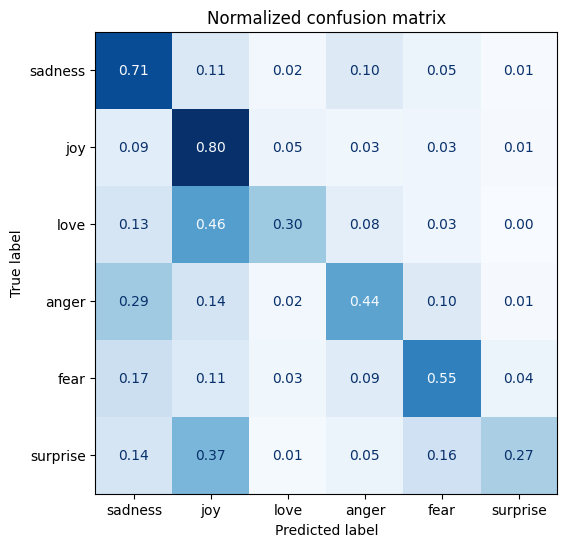

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fix, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

We can see that anger and fear are most often confused with sadness, which agrees
with the observation we made when visualizing the embeddings. Also, love and
surprise are frequently mistaken for joy.

In the next section we will explore the fine-tuning approach, which leads to superior
classification performance. It is, however, important to note that doing this requires
more computational resources, such as GPUs, that might not be available in your
organization. In cases like these, a feature-based approach can be a good compromise
between doing traditional machine learning and deep learning.

In [47]:
# Option two: Fine-Tuning Transformers
# With the fine-tuning approach we do not use the hidden states as fixed features, but instead train them

# Loading a pretrained model
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'pre_classifier.we

In [48]:
# Defining the performance metrics
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)

  return {"accuracy": acc, "f1": f1}

In [56]:
# Training the model
# 1. Login to Hugging Face Hub. This will allow us to push our fine-tuned model to our account
from huggingface_hub import notebook_login

notebook_login()

In [57]:
# 2. Define the training params
# We use the TrainingArguments class. This class
# stores a lot of information and gives you fine-grained control over the training and
# evaluation. The most important argument to specify is output_dir, which is where
# all the artifacts from training are stored.

from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetunde-emotion"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error")
# Here we also set the batch size, learning rate, and number of epochs, and specify to
# load the best model at the end of the training run.

In [58]:
# Instantiate and fine_tune our model with the Trainer
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
compute_metrics=compute_metrics,
train_dataset=emotions_encoded["train"],
eval_dataset=emotions_encoded["validation"],
tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/alaeddinehamroun/distilbert-base-uncased-finetunde-emotion into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.830400,0.326606,0.900500,0.897007
2,0.253800,0.225067,0.921500,0.921737


In [59]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [60]:
preds_output.metrics

{'test_loss': 0.22506652772426605,
 'test_accuracy': 0.9215,
 'test_f1': 0.9217368692620141,
 'test_runtime': 4.4127,
 'test_samples_per_second': 453.232,
 'test_steps_per_second': 7.252}

In [61]:
y_preds = np.argmax(preds_output.predictions, axis=1)

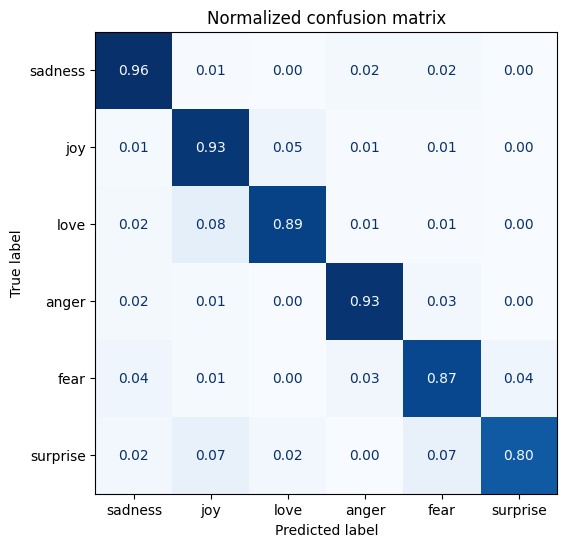

In [62]:
plot_confusion_matrix(y_preds, y_valid, labels)

This is much closer to the ideal diagonal confusion matrix. The love category is still
often confused with joy, which seems natural. surprise is also frequently mistaken
for joy, or confused with fear.

In [63]:
# Error analysis

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device), reduction="none")
  # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

In [64]:
# Get the losses for all the samples

# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [65]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
.apply(label_int2str))

In [66]:
# Look at the data samples with the highest losses
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,5.954078
882,i feel badly about reneging on my commitment t...,love,sadness,5.528685
1801,i feel that he was being overshadowed by the s...,love,sadness,5.462533
465,i would eventually go in to these stores but i...,joy,fear,5.455673
1274,i am going to several holiday parties and i ca...,joy,sadness,5.437659
765,i feel super awkward and out of place right now,joy,sadness,5.259309
1509,i guess this is a memoir so it feels like that...,joy,fear,5.189106
1963,i called myself pro life and voted for perry w...,joy,sadness,4.882952
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.870529
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.610982


We can clearly see that the model predicted some of the labels incorrectly. On the
other hand, it seems that there are quite a few examples with no clear class, which
might be either mislabeled or require a new class altogether. In particular, joy seems
to be mislabeled several times. With this information we can refine the dataset, which
often can lead to as big a performance gain (or more) as having more data or larger
models!

When looking at the samples with the lowest losses, we observe that the model seems
to be most confident when predicting the sadness class. Deep learning models are
exceptionally good at finding and exploiting shortcuts to get to a prediction. For this
reason, it is also worth investing time into looking at the examples that the model is
most confident about, so that we can be confident that the model does not improp‐
erly exploit certain features of the text.

In [67]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have ...,joy,joy,0.015848
1638,i feel like if you shop smart you can still ad...,joy,joy,0.016403
19,i had lunch with an old friend and it was nice...,joy,joy,0.016473
131,i feel like a graph doesnt show the data accur...,joy,joy,0.016498
69,i have no extra money im worried all of the ti...,sadness,sadness,0.016576
205,i cannot wait for school to end so i can chang...,joy,joy,0.016776
951,i have to force myself to do it because i am a...,joy,joy,0.016801
1219,im feeling the christmas spirit so it seems li...,joy,joy,0.016803
1172,i feel like i dont need school to be intelligent,joy,joy,0.016946
856,i feel is more energetic in urban singapore th...,joy,joy,0.016952


In [68]:
# Saving and sharing the model
trainer.push_to_hub(commit_message="Training completed!")

To https://huggingface.co/alaeddinehamroun/distilbert-base-uncased-finetunde-emotion
   8fdae86..3216b5d  main -> main

   8fdae86..3216b5d  main -> main

To https://huggingface.co/alaeddinehamroun/distilbert-base-uncased-finetunde-emotion
   3216b5d..79fb4f1  main -> main

   3216b5d..79fb4f1  main -> main



'https://huggingface.co/alaeddinehamroun/distilbert-base-uncased-finetunde-emotion/commit/3216b5da0b6e509eda8509c72d13350e0fa08435'

In [69]:
# Use the fine-tuned model to make predictions on new tweets

from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [70]:
custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


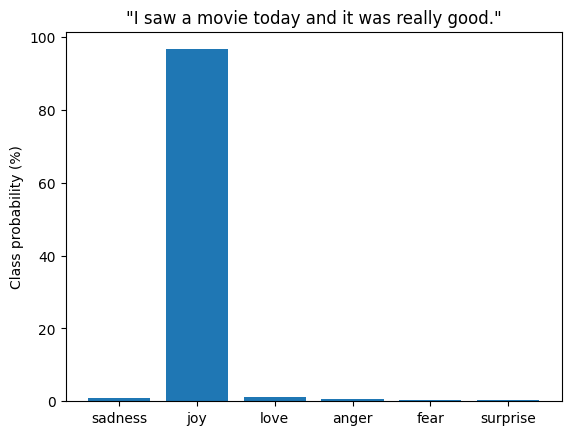

In [71]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()